In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import os
import cv2 as cv
from keras.layers import Dense
import pandas as pd
from functools import partial
import keras as keras
import pathlib
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [ ]:
from pathlib import Path
import imghdr

data_dir = "/content/drive/MyDrive/Waste_Classification/Dataset_Resized"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [ ]:
!pip install split-folders[full]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders
splitfolders.ratio('/content/drive/MyDrive/Waste_Classification/Dataset_Resized', 
                    output="Split_Dataset", 
                    seed=1337, 
                    ratio=(.75,0.15,0.1))

Copying files: 4369 files [00:10, 406.98 files/s]


In [ ]:
dataset_size = tf.keras.preprocessing.image_dataset_from_directory('/content/drive/MyDrive/Waste_Classification/Dataset_Resized', batch_size = None)

Found 4369 files belonging to 9 classes.


In [ ]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/Split_Dataset/train',
    seed=42, 
    batch_size = None)

Found 3275 files belonging to 9 classes.


In [ ]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/Split_Dataset/val', 
    seed=42, 
    batch_size = None)

Found 651 files belonging to 9 classes.


In [ ]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/Split_Dataset/test', 
    seed=42, 
    batch_size = None)

Found 443 files belonging to 9 classes.


In [ ]:
classes = train_dataset.class_names
numClasses = len(train_dataset.class_names)
print(classes)
print(numClasses)

['Aluminium', 'Cardboard', 'Glass', 'Organic Waste', 'Other Plastics', 'Paper', 'Plastic', 'Textiles', 'Wood']
9


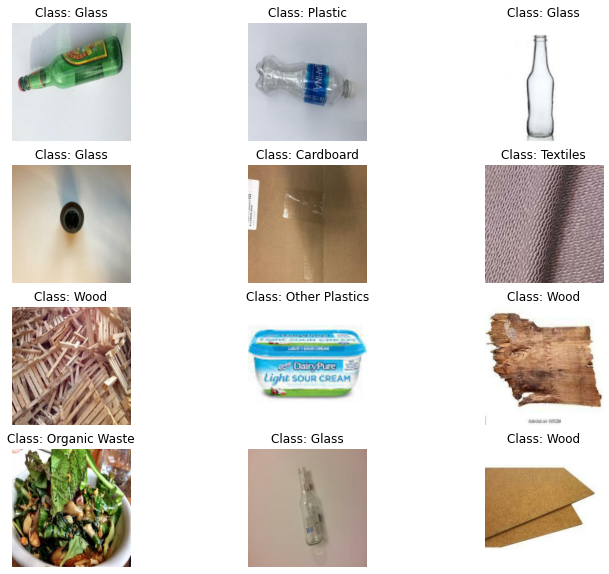

In [ ]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_dataset.take(12):
    index += 1
    plt.subplot(4, 3, index)
    plt.imshow(image.astype('uint8'))
    plt.title("Class: {}".format(classes[label]))
    plt.axis("off")

plt.show()

In [ ]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_dataset.shuffle(1000).repeat()
train_set = train_dataset.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
val_set = val_dataset.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_dataset.map(preprocess).batch(batch_size).prefetch(1)

In [ ]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(numClasses, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

83697664/83683744 [==============================] - 0s 0us/step


In [ ]:
# it’s usually a good idea to freeze the weights of the 
# pretrained layers, at least at the beginning of training:
for layer in base_model.layers:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    #steps_per_epoch=(0.75 * (dataset_size / batch_size)),
                    validation_data=val_set,
                    #validation_steps=(0.15 * (dataset_size / batch_size)),
                    epochs=5)

Epoch 1/5
103/103 [==============================] - 31s 161ms/step - loss: 0.8524 - accuracy: 0.7179 - val_loss: 0.4835 - val_accuracy: 0.8571
Epoch 2/5
103/103 [==============================] - 17s 150ms/step - loss: 0.4275 - accuracy: 0.8748 - val_loss: 0.4281 - val_accuracy: 0.8710
Epoch 3/5
103/103 [==============================] - 17s 151ms/step - loss: 0.3749 - accuracy: 0.8907 - val_loss: 0.4049 - val_accuracy: 0.8786
Epoch 4/5
103/103 [==============================] - 17s 153ms/step - loss: 0.3541 - accuracy: 0.8989 - val_loss: 0.3879 - val_accuracy: 0.8802
Epoch 5/5
103/103 [==============================] - 17s 157ms/step - loss: 0.3364 - accuracy: 0.8980 - val_loss: 0.3792 - val_accuracy: 0.8802


In [ ]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, epochs=10, validation_data=val_set)

Epoch 1/10
103/103 [==============================] - 74s 644ms/step - loss: 0.5998 - accuracy: 0.8504 - val_loss: 0.3931 - val_accuracy: 0.8879
Epoch 2/10
103/103 [==============================] - 65s 625ms/step - loss: 0.3725 - accuracy: 0.9053 - val_loss: 0.3450 - val_accuracy: 0.8986
Epoch 3/10
103/103 [==============================] - 65s 624ms/step - loss: 0.3013 - accuracy: 0.9252 - val_loss: 0.3105 - val_accuracy: 0.9109
Epoch 4/10
103/103 [==============================] - 66s 626ms/step - loss: 0.2449 - accuracy: 0.9383 - val_loss: 0.2865 - val_accuracy: 0.9263
Epoch 5/10
103/103 [==============================] - 66s 626ms/step - loss: 0.2190 - accuracy: 0.9408 - val_loss: 0.2667 - val_accuracy: 0.9263
Epoch 6/10
103/103 [==============================] - 67s 644ms/step - loss: 0.1904 - accuracy: 0.9560 - val_loss: 0.2539 - val_accuracy: 0.9309
Epoch 7/10
103/103 [==============================] - 67s 644ms/step - loss: 0.1790 - accuracy: 0.9582 - val_loss: 0.2443 - val_ac

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 9.9916911e-01
  0.0000000e+00 0.0000000e+00 0.0000000e+00 8.3085493e-04]]
Prediction: Other Plastics


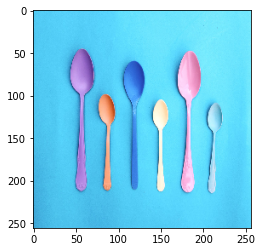

In [ ]:
path = "/content/Spoon.jpg"

img = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)

plt.imshow(img)
print(predictions)
print("Prediction: " + str(classes[np.argmax(predictions)]))